# 1. Introducción (Markdown)

# Model Training — Retail Sales Prediction

Este notebook entrena y evalúa modelos de Machine Learning para
predecir ventas futuras de clientes.

Pipeline del proyecto:

EDA → Feature Engineering → Dataset listo → Model Training → API → Docker → Airflow

Objetivos:
- Entrenar modelos reproducibles
- Comparar rendimiento
- Analizar importancia de variables
- Guardar modelo final para producción


# 2. Imports

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import joblib



# 3. Cargar dataset listo

In [2]:
PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "outputs"

df = pd.read_csv(DATA_PATH / "dataset_model_ready.csv")

print("Shape:", df.shape)
df.head()




Shape: (5000, 10)


,age,income,purchase_frequency,avg_ticket,recency_days,online_ratio,future_sales,high_value_customer,freq_per_day,engagement_score
0,56,58353.457443,11,58.722302,285,0.951013,402.149162,0,0.038462,0.945427
1,69,67462.278860,7,56.573908,153,0.801525,418.461486,0,0.045455,0.049258
2,46,54219.250087,14,55.370637,40,0.205749,749.016655,1,0.341463,0.125423
3,32,66306.787159,7,75.118287,26,0.391301,423.560829,0,0.259259,-0.664671
4,60,47034.133936,9,122.306864,273,0.927792,452.521689,0,0.032847,0.587011


# 4. Definir variables

In [3]:
TARGET = "future_sales"

X = df.drop(columns=[TARGET])
y = df[TARGET]

print("Features:", X.shape)
print("Target:", y.shape)


Features: (5000, 9)
Target: (5000,)


# 5. Train/Test split reproducible

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (4000, 9)
Test: (1000, 9)


# 6. Entrenamiento de modelos

In [5]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        random_state=42
    ),
}

results = {}

for name, model in models.items():
    print(f"Entrenando {name}...")
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds),
    }

results_df = pd.DataFrame(results).T
results_df.sort_values("R2", ascending=False)



Entrenando LinearRegression...
Entrenando RandomForest...
Entrenando GradientBoosting...


,MAE,RMSE,R2
RandomForest,81.291023,104.037637,0.900220
GradientBoosting,82.938856,104.140508,0.900023
LinearRegression,98.738497,134.638917,0.832890


# 7. Selección del mejor modelo

In [6]:
best_model_name = results_df["R2"].idxmax()
best_model = models[best_model_name]

print("Mejor modelo:", best_model_name)


Mejor modelo: RandomForest


# 8. Importancia de variables

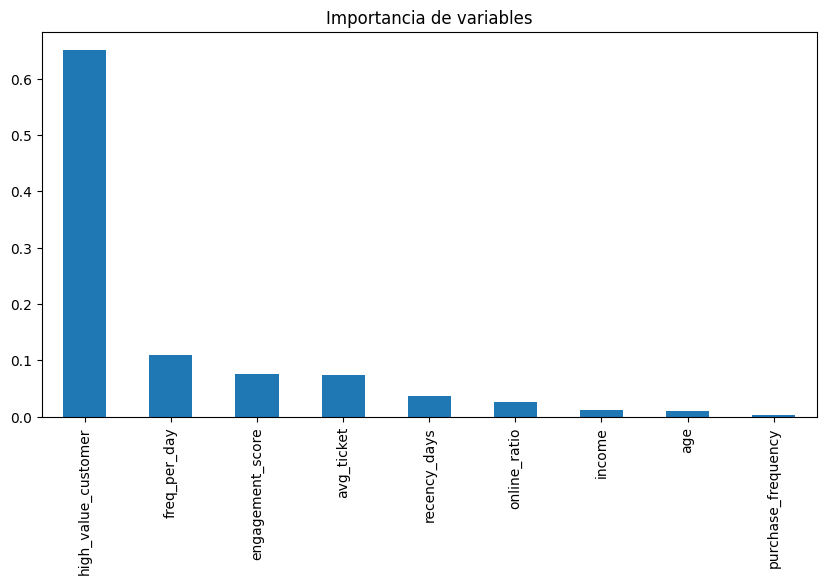

In [7]:
if hasattr(best_model, "feature_importances_"):
    
    feature_importance = pd.Series(
        best_model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    feature_importance.head(15).plot(
        kind="bar",
        title="Importancia de variables",
        figsize=(10, 5)
    )


# 9. Guardar modelo para producción

In [8]:
MODEL_PATH = PROJECT_ROOT / "models"
MODEL_PATH.mkdir(exist_ok=True)

joblib.dump(
    best_model,
    MODEL_PATH / "retail_sales_model.pkl"
)

print("Modelo guardado correctamente")


Modelo guardado correctamente


# 10. Conclusión (Markdown)

## Conclusión

Se entrenaron múltiples modelos y se seleccionó el mejor según R².

El modelo final queda disponible para:

- API FastAPI
- Docker deployment
- Reentrenamiento con Airflow
- Producción
